In [3]:
import pandas as pd

df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')

df.head()

,itemid,orderdate,qty,amount
0,SFG633,01-01-2022,9.0,270.09
1,6010101,01-01-2022,6.0,408.84
2,R00010,01-01-2022,40.0,2176.20
3,R00429,01-01-2022,21.0,1387.75
4,RMD0460,01-01-2022,15.0,486.00


In [5]:
# Group by 'itemid' and count the number of occurrences
item_counts = df['itemid'].value_counts()

print(item_counts)

itemid
SFG648     701
R00513     700
SFG152     698
A00123     697
R00526     697
          ... 
SFG588       1
SFG374       1
SFG370       1
SFG373       1
RMD0651      1
Name: count, Length: 1112, dtype: int64


#### FILTERING THE ITEMID

In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Load your data


df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')

# Convert 'orderdate' to datetime
df['orderdate'] = pd.to_datetime(df['orderdate'], format='%d-%m-%Y')


# Step 2: Filter data for a specific itemid
itemid = 'SFG633'
filtered_data = df[df['itemid'] == itemid]

filtered_data.head()

,itemid,orderdate,qty,amount
0,SFG633,2022-01-01,9.0,270.09
194,SFG633,2022-01-02,1.0,30.01
287,SFG633,2022-01-03,2.0,60.02
567,SFG633,2022-01-05,2.0,60.02
605,SFG633,2022-01-06,3.0,90.03


In [12]:
date_range = pd.date_range(start='2022-12-01', end='2022-12-31', freq='D')

# Step 4: Reindex the filtered data to include all dates in the date range
filtered_data.set_index('orderdate', inplace=True)
filtered_data = filtered_data.reindex(date_range, fill_value=0)

# Step 5: Reset the index to have 'orderdate' as a column again
filtered_data.reset_index(inplace=True)
filtered_data.rename(columns={'index': 'orderdate'}, inplace=True)

# Display the modified DataFrame
filtered_data.head()

,orderdate,itemid,qty,amount
0,2022-12-01,SFG633,1.0,30.01
1,2022-12-02,0,0.0,0.00
2,2022-12-03,0,0.0,0.00
3,2022-12-04,SFG633,1.0,30.01
4,2022-12-05,0,0.0,0.00


In [14]:
fdf = filtered_data.drop(['itemid', 'qty'], axis=1)
fdf.reset_index()
fdf.head()

,orderdate,amount
0,2022-12-01,30.01
1,2022-12-02,0.00
2,2022-12-03,0.00
3,2022-12-04,30.01
4,2022-12-05,0.00


#### RENAMING THE COLUMNS
 BECAUSE IN PROPHET MODLE IT IS COMPLUSION FOR PRIDICTIED VALUES COLUMN SHOULD BE NAMED 'Y' AND THE DATE/TIME CLOUMN SHOULD BE NAMED ds''

In [17]:
# Rename columns for Prophet
fdf.columns = ['ds', 'y']
fdf.head()

,ds,y
0,2022-12-01,30.01
1,2022-12-02,0.00
2,2022-12-03,0.00
3,2022-12-04,30.01
4,2022-12-05,0.00


##### SETTING THE VALUES FOR TEST AND TRAIN

In [31]:
train = fdf[fdf['ds'] < '2022-12-01']
test = fdf[(fdf['ds'] >= '2022-12-01') & (fdf['ds'] < '2023-01-01')]


##### MODEL

In [34]:
from prophet import Prophet

# Initialize the model
model = Prophet()

# Fit the model
model.fit(train)


ValueError: Dataframe has less than 2 non-NaN rows.

In [27]:
# Create a dataframe for future dates
future_dates = pd.date_range(start='2022-12-01', end='2022-12-31')
future = pd.DataFrame({'ds': future_dates})

future.tail()


,ds
26,2022-12-27
27,2022-12-28
28,2022-12-29
29,2022-12-30
30,2022-12-31


In [29]:
# Make predictions
forecast = model.predict(future)

Exception: Model has not been fit.

In [61]:
# Get predicted values for December 2022
predicted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Merge with actual values
comparison = pd.merge(predicted_values, test, on='ds', how='left', suffixes=('_predicted', '_actual'))

# Print the results
print(comparison)


           ds        yhat  yhat_lower  yhat_upper       y
0  2022-12-01  106.539607   -1.703027  209.705384   30.01
1  2022-12-02   78.646958  -24.677546  170.251380     NaN
2  2022-12-03   56.750667  -35.964000  154.383797     NaN
3  2022-12-04   64.791909  -41.351951  167.014361   30.01
4  2022-12-05   81.115815  -17.871623  182.362060     NaN
5  2022-12-06   37.567771  -57.372046  139.492013     NaN
6  2022-12-07   65.845765  -27.791342  166.158875   30.01
7  2022-12-08  106.108629    3.864855  206.676273  120.04
8  2022-12-09   78.215980  -23.494116  184.669568   90.03
9  2022-12-10   56.319689  -47.809974  143.831437     NaN
10 2022-12-11   64.360931  -38.426635  162.934139     NaN
11 2022-12-12   80.684837  -22.509374  179.748338     NaN
12 2022-12-13   37.136793  -60.103220  139.862498   90.03
13 2022-12-14   65.414787  -39.640760  166.422147   30.01
14 2022-12-15  105.677651    9.341189  203.302946  150.05
15 2022-12-16   77.785002  -17.914750  178.858642   30.01
16 2022-12-17 

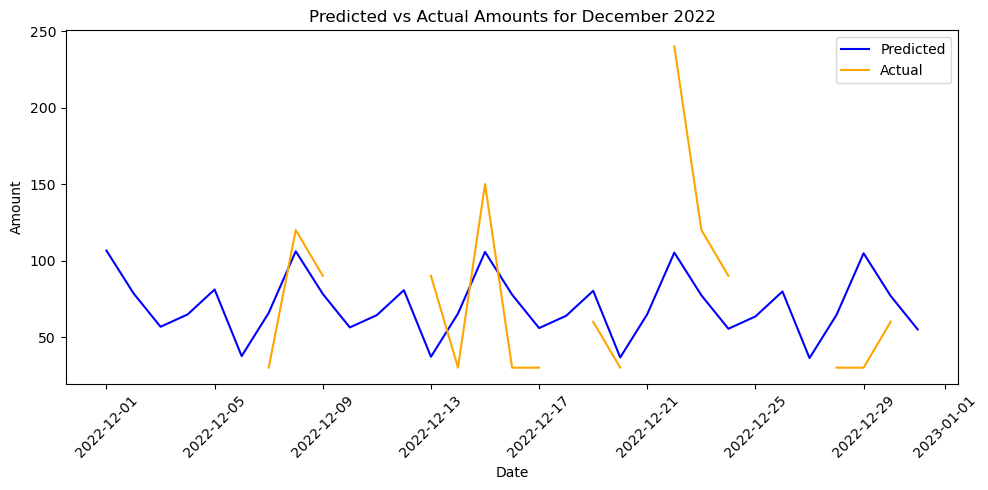

In [65]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='blue')
plt.plot(comparison['ds'], comparison['y'], label='Actual', color='orange')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Predicted vs Actual Amounts for December 2022')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
